# Measuring Size of Objects


<div class="alert alert-block alert-info">
<b>Note: For this to work properly:
    <ul>
    <li> the objects shoud be in the same plane as reference object, and</li>
    <li> the images should taken from an angle perpendicular to the plane of the reference object</li>
     </ul>
</b>    
</div>    

## The “pixels per metric” ratio
In order to determine the size of an object in an image, we first need to perform a “calibration” using a reference object. Our reference object should have two important properties:

 - **Property #1:** We should know the dimensions of this object (in terms of width or height) in a measurable unit (such as millimeters, inches, etc.).
 - **Property #2:** We should be able to easily find this reference object in an image, either based on the placement of the object (such as the reference object always being placed in the top-left corner of an image) or via appearances (like being a distinctive color or shape, unique and different from all other objects in the image). In either case, our reference should should be uniquely identifiable in some manner.
 
We’ll be using the United States quarter as our reference object and throughout all examples, ensure it is always the left-most object in our image:

<img src='https://www.pyimagesearch.com/wp-content/uploads/2016/03/size_of_objects_reference-768x576.jpg'>


By ___guaranteeing the quarter is the left-most object___, we can sort our object contours from left-to-right, grab the quarter (which will always be the first contour in the sorted list), and use it to define our pixels_per_metric, which we define as:

$Pixels\, per\, metric = \frac{Object\, width(in\, pixels)}{Known\, width}$

A US quarter has a known_width of 0.955 inches. Now, suppose that our object_width (measured in pixels) is computed be 150 pixels wide (based on its associated bounding box).

The pixels_per_metric is therefore:

$Pixels\, per\, metric = \frac{150px}{0.955}= 157px$

Thus implying there are _approximately 157 pixels per every 0.955 inches_ in our image. Using this ratio, we can compute the size of objects in an image.


## Let's get on to the code

In [60]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# returns the mid point between two points
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

_midpoint_ is a helper method that returns the midpoint of an object

Let's load the image an perform some common preprocessing to detect edges adn visualiize every thing on the way.

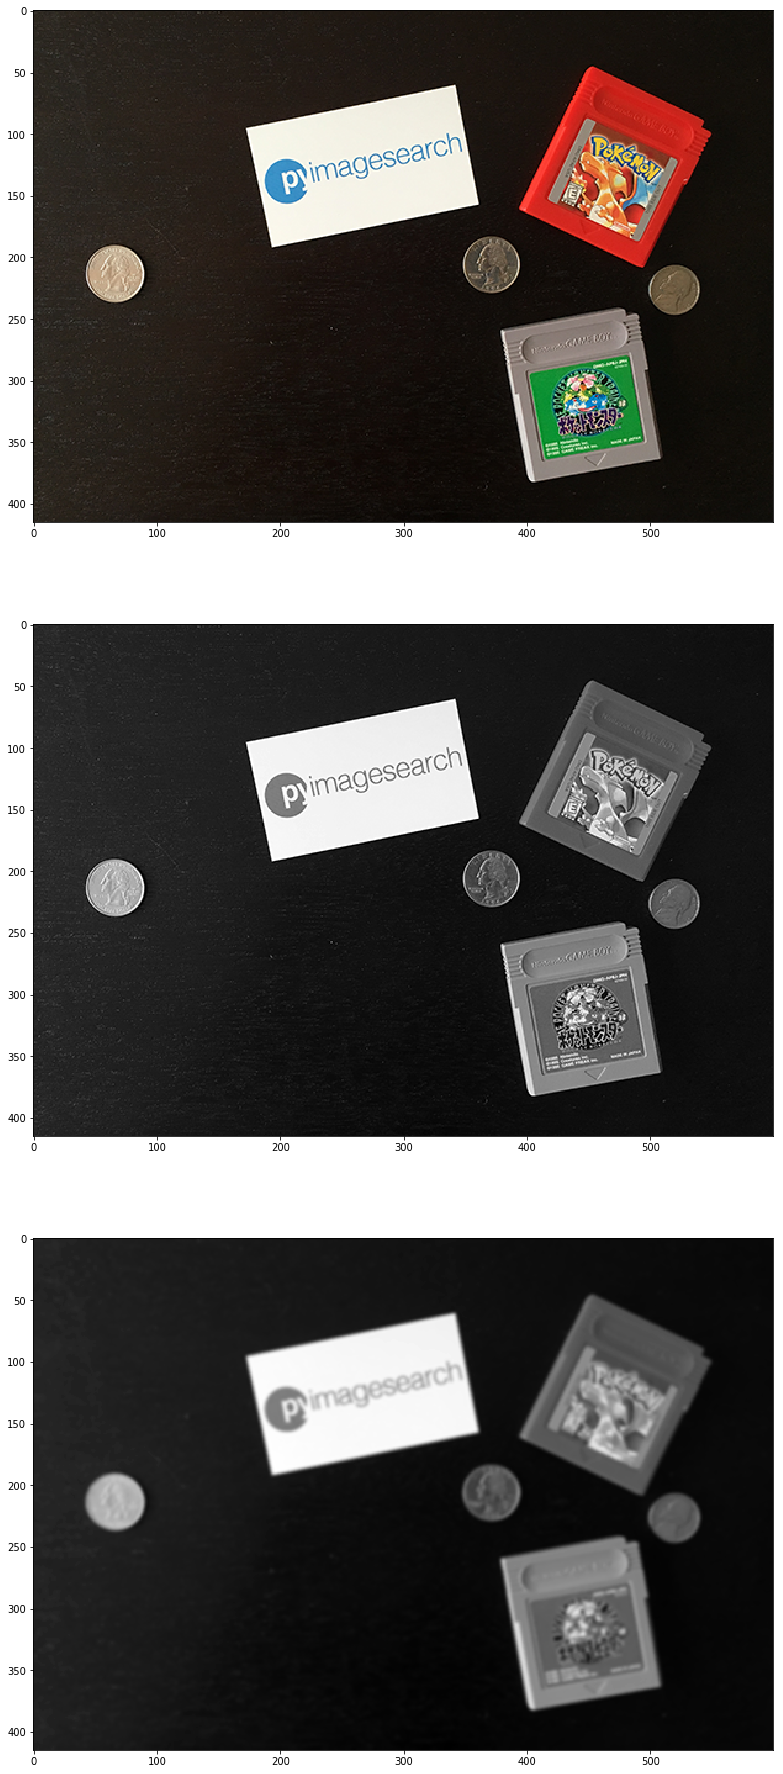

In [79]:
fig, ax = plt.subplots(3, 1, figsize=(16,32))
# load the image, convert it to grayscale, and blur it slightly
image_path = "images\\example_01.png"
image = cv2.imread(image_path)
ax[0].imshow(image[...,::-1])

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[1].imshow(gray, cmap='gray')

gray = cv2.GaussianBlur(gray, (7,7), 0)
ax[2].imshow(gray, cmap='gray')

plt.show()

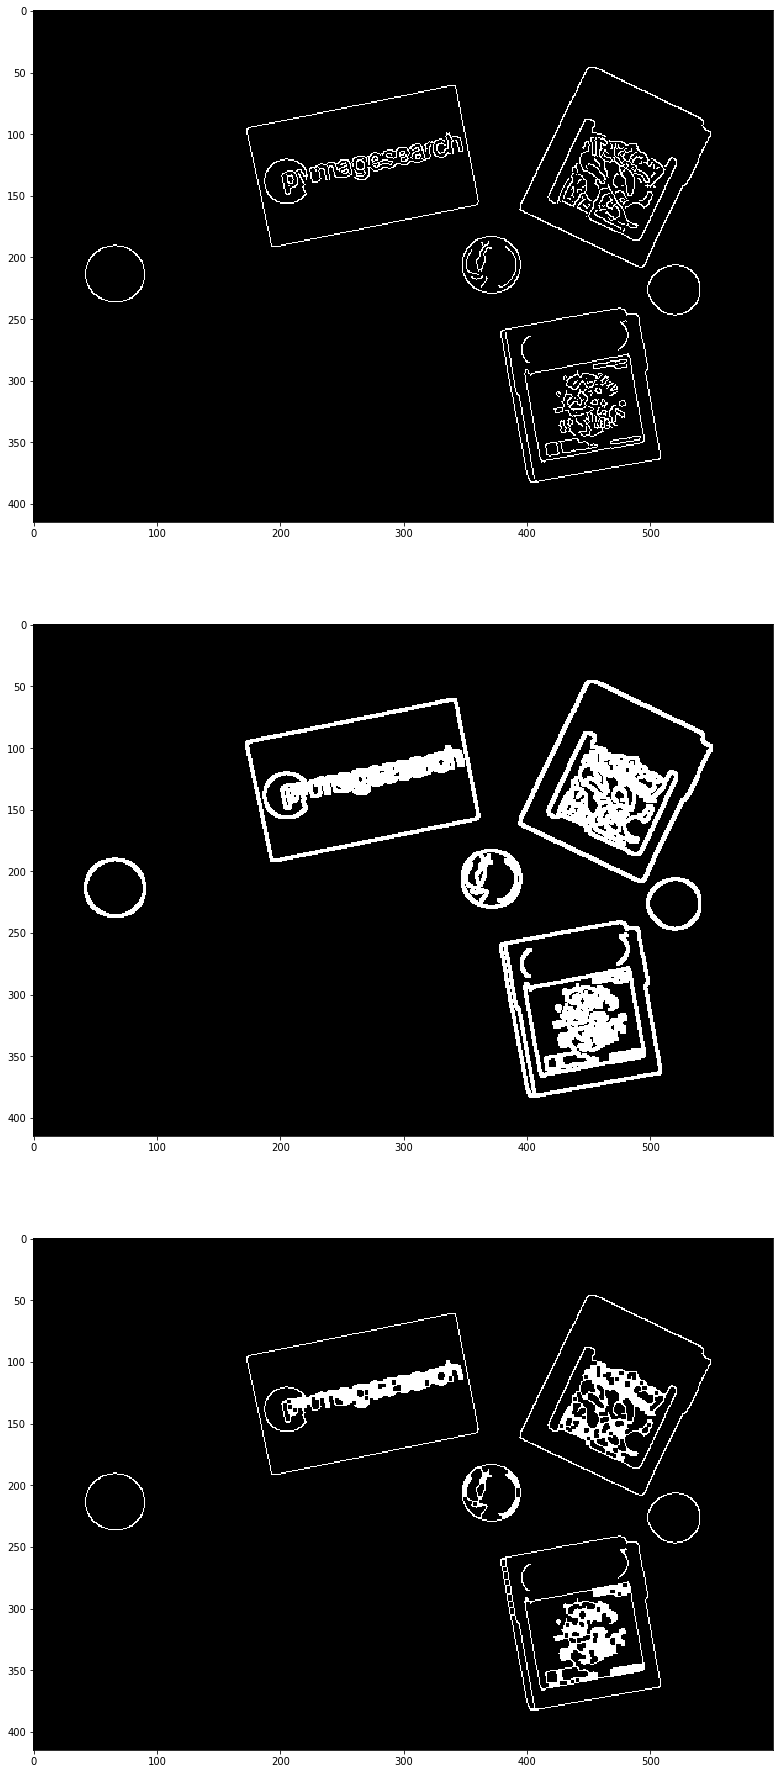

In [80]:
fig, ax = plt.subplots(3, 1, figsize=(16,32))

# perform edge detection, then perform dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
ax[0].imshow(edged, cmap='gray')

edged = cv2.dilate(edged, kernel=None, iterations=1)
ax[1].imshow(edged, cmap='gray')

edged = cv2.erode(edged, kernel= None, iterations=1)
ax[2].imshow(edged, cmap='gray')

plt.show()


In the last image, now the edges are more prominient and filled in compared to the first edged image.

Now we can sort the contours from left-to-right and start are pixel-per-metric measuring process

In [81]:
# find the contours in the edged map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

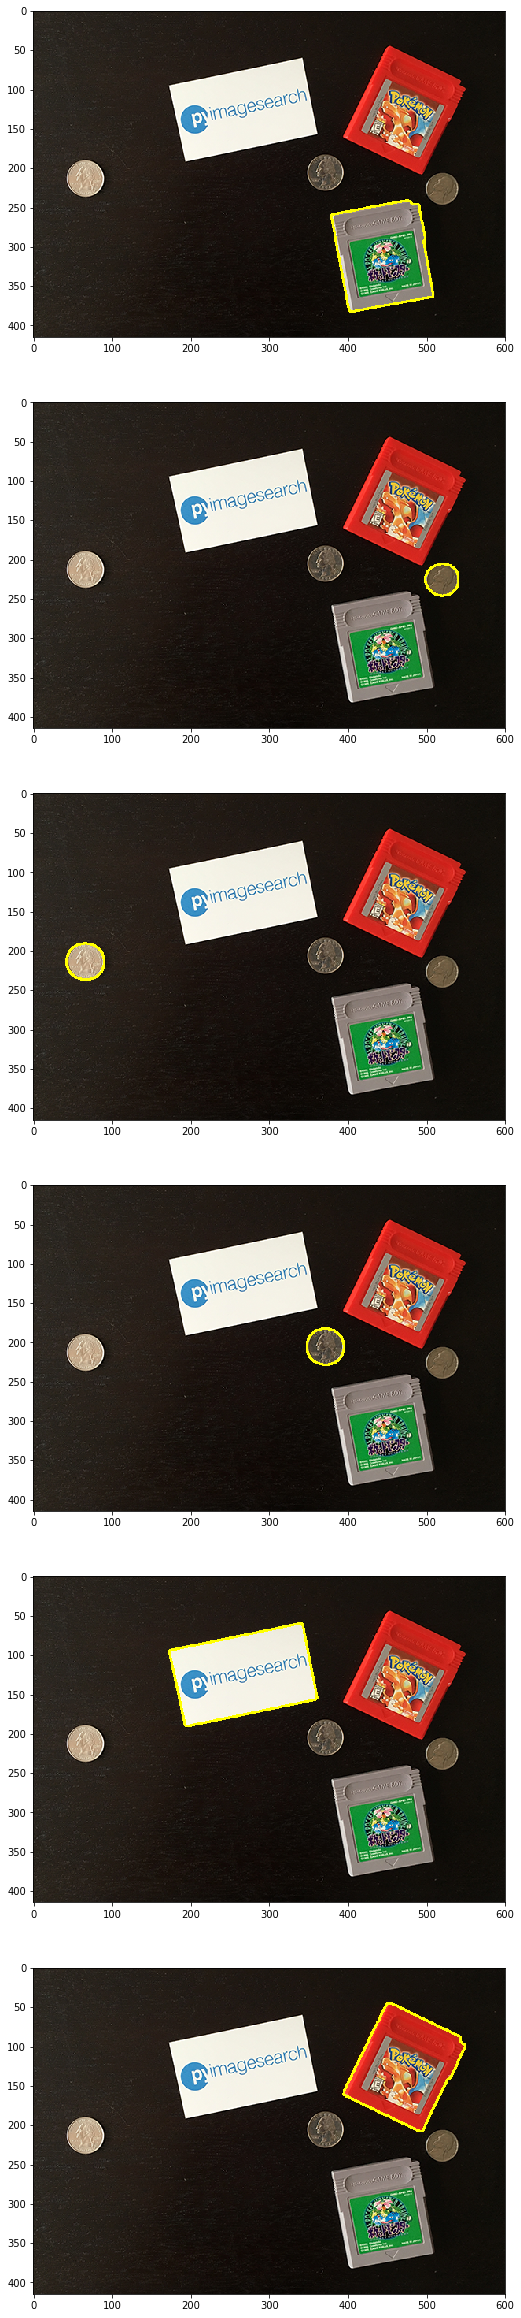

In [82]:
# lets take look how the contours are arranged before we sort them
fig, ax = plt.subplots(6, 1, figsize=(11,42)) # 6 because 6 objects in 
                                              # the image

# contours are outlined in yellow   
for i in range(len(cnts)):
    ax[i].imshow(cv2.drawContours(image.copy(), cnts, contourIdx=i,
                                  color=(0,255,255), thickness=2)[...,::-1])

plt.show()

As seen from the outlines drawn above, from the countours array, there is no specific order to them lets sort them so that the contours are sorted left to right

In [83]:
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

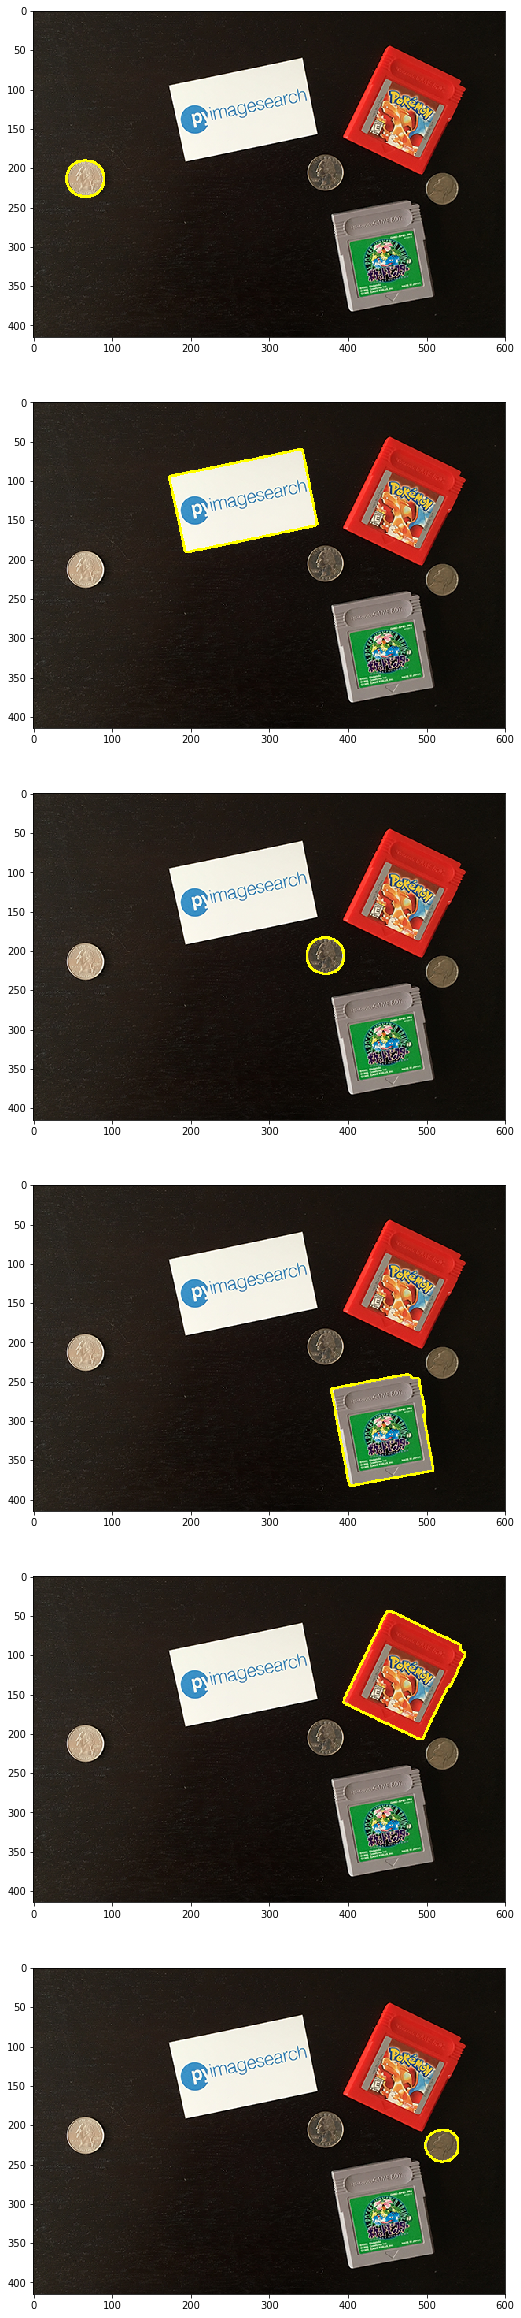

In [84]:
# lets take look how the contours are arranged before we sort them
fig, ax = plt.subplots(6, 1, figsize=(11,42)) # 6 because 6 objects in 
                                              # the image

# contours are outlined in yellow   
for i in range(len(cnts)):
    ax[i].imshow(cv2.drawContours(image.copy(), cnts, contourIdx=i,
                                  color=(0,255,255), thickness=2)[...,::-1])

plt.show()

All the contours are now sorted left-to-right. As seen form the six images above.

Next we need to loop over each contours to find their dimensions and draw them 

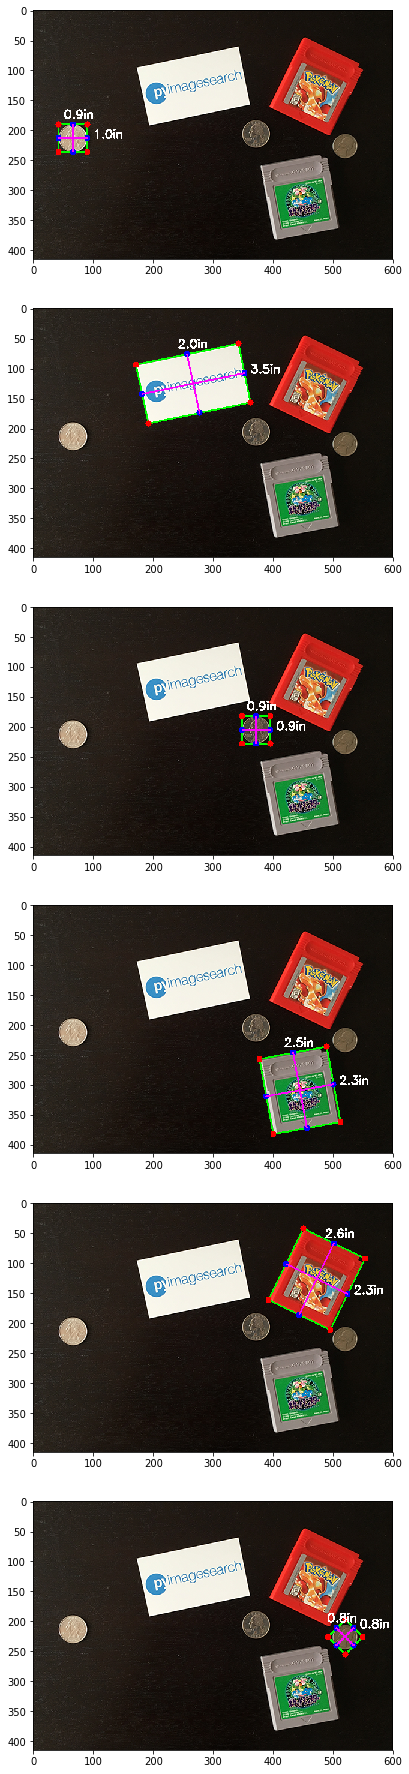

In [85]:
fig, ax = plt.subplots(6, 1, figsize=(11,32)) # 6 because 6 objects in 
                                              # the image
ax_iter = 0

# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
    
    # compute rotated bounding box of the contour
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    
    # order the points in the contour such that they appear
    # in the top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0,255,0), 2)
    
    # loop over the corners and draw them
    for (x, y) in box:
        cv2.circle(orig, center=(int(x), int(y)), radius=5, 
                   color=(0,0,255), thickness=-1)
        
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and the top-right coordinates, followed
    # by the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and bottom-left points,
    # followed by the midpoint between the top-right and bottom-right
    # points
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
    
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
    
    
    # draw cross between the midpoints
    cv2.line(orig, pt1=(int(tltrX), int(tltrY)), pt2=(int(blbrX), int(blbrY)),
            color=(255, 0, 255), thickness=2)
    
    cv2.line(orig, pt1=(int(tlblX), int(tlblY)), pt2=(int(trbrX), int(trbrY)),
            color=(255, 0, 255), thickness=2)
    
    
    # compute Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    
    # if the pixels per metric has not been initialize, then
    # compute it as the ratio of pixels to the supplied metric
    # (the size of coin in this case, in inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / 0.955
        
    # now we can compute the size of object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
    
    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}in".format(dimA), org = (int(tltrX -15), int(tltrY -10)), 
                fontFace=  cv2.FONT_HERSHEY_SIMPLEX, fontScale =0.65, color=(255,255,255), thickness=2)
    cv2.putText(orig, "{:.1f}in".format(dimB), org = (int(trbrX +10), int(trbrY)), 
                fontFace=  cv2.FONT_HERSHEY_SIMPLEX, fontScale =0.65, color=(255,255,255), thickness=2)
    
    # plot the images
    ax[ax_iter].imshow(orig[...,::-1])
    ax_iter+=1

plt.show()

_How come the object measurements are not 100% accurate?_

The reason is two-fold:

- First, the angle is most certainly not a perfect 90-degree angle “looking down” (like a birds-eye-view) at the objects. Without a perfect 90-degree view (or as close to it as possible), the dimensions of the objects can appear distorted.
- Second, I did not calibrate my iPhone using the intrinsic and extrinsic parameters of the camera. Without determining these parameters, photos can be prone to radial and tangential lens distortion. Performing an extra calibration step to find these parameters can “un-distort” our image and lead to a better object size approximation 
- In the meantime, strive to obtain as close to a 90-degree viewing angle as possible when taking photos of your objects — this will help increase the accuracy of your object size estimation.